In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cvxpy as cp

from interval import interval, inf, imath

from safe_train import *
from projection_examples import projection_training_loop

Instructions for updating:
non-resource variables are not supported in the long term


/Users/nishant/Documents/Marabou/maraboupy/Marabou.py:31: UserWarning: ONNX parser is unavailable because onnx or onnxruntime packages are not installed
  warnings.warn("ONNX parser is unavailable because onnx or onnxruntime packages are not installed")


# Generate mid-dimensional data

4-5 dim curve fitting

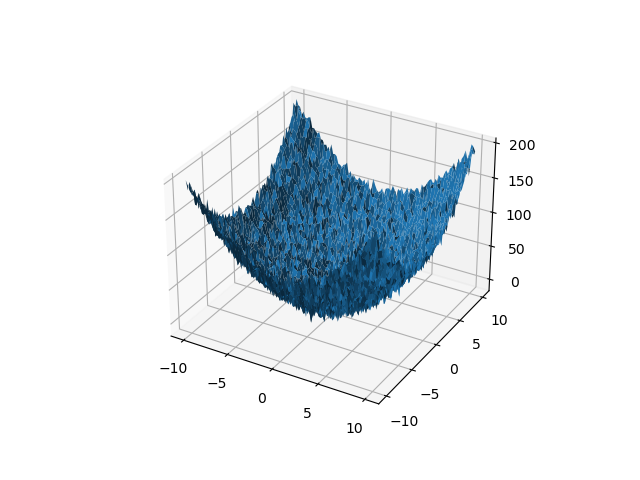

In [2]:
NOISE_STD = 5
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)
z = x**2 + y**2 + np.random.standard_normal(x.shape)*NOISE_STD

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
ax.plot_surface(x, y, z)
# ax.set_zlim(-1, 101)
plt.show()

In [3]:
z.shape

(100, 100)

In [4]:
NOISE_STD = 5
data_n = 11
x = np.linspace(-10, 10, data_n)
y = np.linspace(-10, 10, data_n)
x1 = np.linspace(-4, 4, data_n)
y1 = np.linspace(-4, 4, data_n)
x, y, x1, y1 = np.meshgrid(x, y, x1, y1)
z = x**2 + y**2 + x1**3 - 0.1*y1**4 + np.random.standard_normal(x.shape)*NOISE_STD

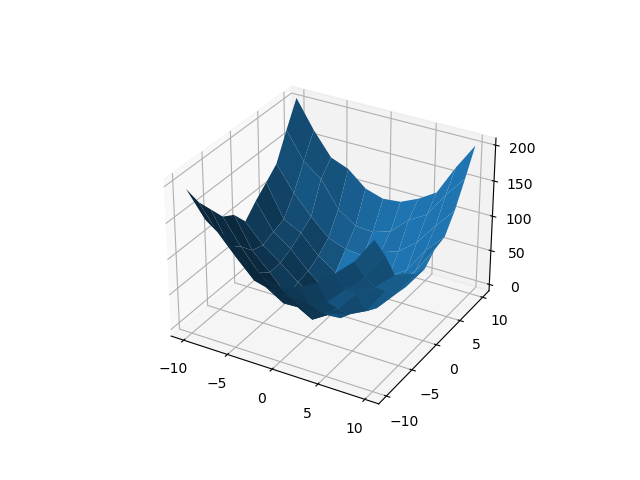

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
x_plot = x[:, :, data_n // 2, data_n // 2]
y_plot = y[:, :, data_n // 2, data_n // 2]
z_plot = z[:, :, data_n // 2, data_n // 2]
ax.plot_surface(x_plot, y_plot, z_plot)
# ax.set_zlim(-1, 101)
plt.show()

In [6]:
z_plot.shape

(11, 11)

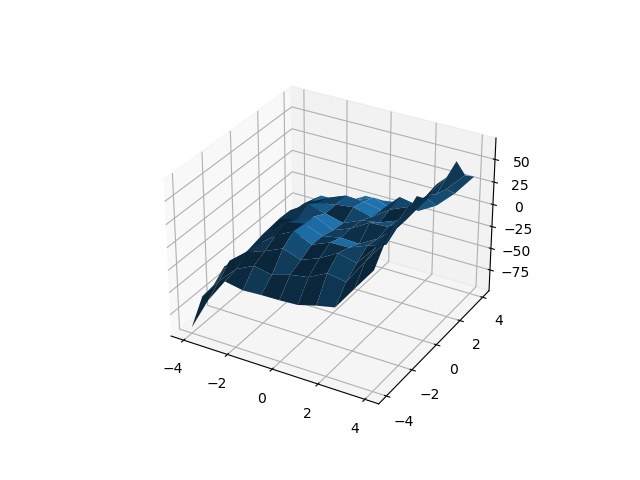

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
x_plot = x1[data_n // 2, data_n // 2, :, :]
y_plot = y1[data_n // 2, data_n // 2, :, :]
z_plot = z[data_n // 2, data_n // 2, :, :]
ax.plot_surface(x_plot, y_plot, z_plot)
# ax.set_zlim(-1, 101)
plt.show()

In [8]:
x_array = x.reshape(-1, 1)
y_array = y.reshape(-1, 1)
x1_array = x1.reshape(-1, 1)
y1_array = y1.reshape(-1, 1)
z_array = z.reshape(-1, 1)
nn_x = np.hstack([x_array, y_array, x1_array, y1_array])

In [9]:
nn_x.shape

(14641, 4)

In [10]:
# normalizer = layers.Normalization(
#     mean=np.mean(nn_x, axis=0),
#     variance=np.var(nn_x, axis=0),    
# )

normalizer = layers.Normalization()
normalizer.adapt(nn_x)

Metal device set to: Apple M1 Pro


In [11]:
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        # layers.Dense(units=2, activation="linear", input_shape=[2]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error"
)

history = regression_model.fit(
    nn_x,
    z_array,
    epochs=8,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 10% of the training data.
    validation_split=0,
)

Epoch 1/8
458/458 [==============================] - 5s 8ms/step - loss: 597.2544
Epoch 2/8
458/458 [==============================] - 3s 7ms/step - loss: 171.6186
Epoch 3/8
458/458 [==============================] - 3s 7ms/step - loss: 137.0768
Epoch 4/8
458/458 [==============================] - 3s 7ms/step - loss: 136.3332
Epoch 5/8
458/458 [==============================] - 3s 7ms/step - loss: 135.1454
Epoch 6/8
458/458 [==============================] - 3s 7ms/step - loss: 92.1620
Epoch 7/8
458/458 [==============================] - 3s 7ms/step - loss: 106.3222
Epoch 8/8
458/458 [==============================] - 3s 6ms/step - loss: 94.7078


458/458 [==============================] - 1s 3ms/step


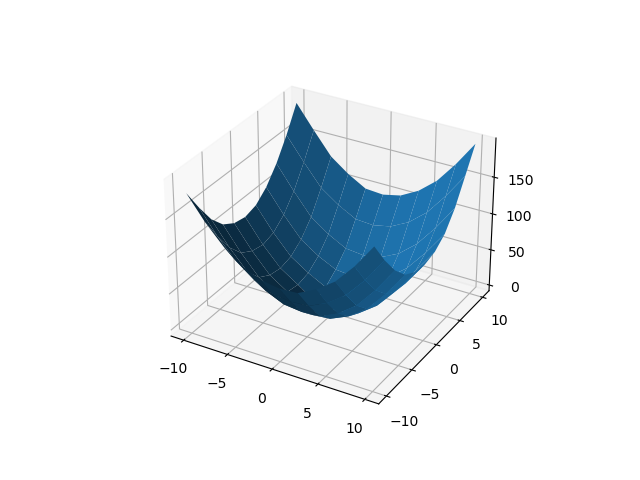

In [12]:
z_predict = regression_model.predict(nn_x)
z_predict_mesh = z_predict.reshape(data_n, data_n, data_n, data_n)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.plot_surface(x[:, :, data_n // 2, data_n // 2], y[:, :, data_n // 2, data_n // 2], z_predict_mesh[:, :, data_n // 2, data_n // 2])

# surf1._edgecolors2d = surf1._edgecolor3d
# surf1._facecolors2d = surf1._facecolor3d

plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

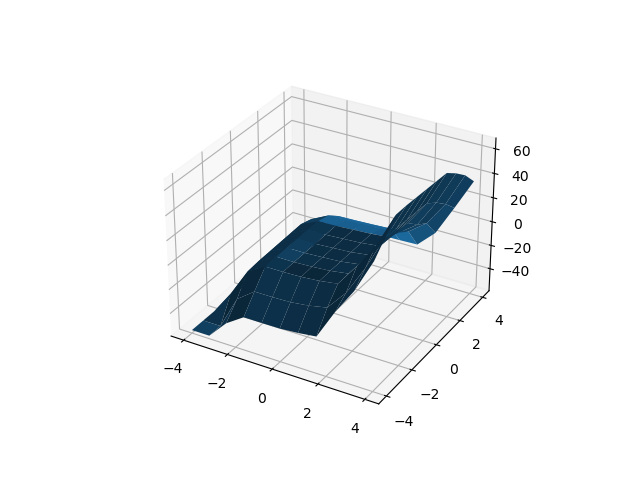

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.plot_surface(x1[data_n // 2, data_n // 2, :, :,], y1[data_n // 2, data_n // 2, :, :,], z_predict_mesh[data_n // 2, data_n // 2, :, :,])

# surf1._edgecolors2d = surf1._edgecolor3d
# surf1._facecolors2d = surf1._facecolor3d

plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

In [14]:
lowers = [[-6, -6, 1.5, -0.4], [1, 1, -1.5, 0.2]]
uppers = [[-5, -5, 1, -0.2], [2, 2, -1, 0.4]]
list(interval[l, u] for l, u in zip(lowers[0], uppers[0]))

[interval([-6.0, -5.0]),
 interval([-6.0, -5.0]),
 interval([1.0, 1.5]),
 interval([-0.4, -0.2])]

In [15]:
regression_model.predict(lowers)

1/1 [==============================] - 0s 132ms/step


array([[69.87958  ],
       [-3.1647573]], dtype=float32)

In [16]:
regression_model.predict(uppers)

1/1 [==============================] - 0s 18ms/step


array([[47.411804],
       [ 5.397201]], dtype=float32)

In [17]:
num_specs = 2

In [18]:
output_interval = [[]] * 2
penultimate_interval = [[]] * 2
for i in range(num_specs):
    input_interval = list(interval[l, u] for l, u in zip(lowers[i], uppers[i]))
    output_interval[i], penultimate_interval[i] = propagate_interval(input_interval, regression_model)
output_interval

[[interval([46.56104698397416, 71.17555100939917])],
 [interval([-3.17163092229446, 5.4208137325429435])]]

In [23]:
def compute_output_interval(lowers, uppers):
    intervals = list(interval[l, u] for l, u in zip(lowers, uppers))
    return [intervals[0] ** 2 + intervals[1] ** 2 + intervals[2]**3 - 0.1*intervals[3]**4]

desired_interval = [[compute_output_interval(lowers[i], uppers[i]) for i in range(num_specs)]]
desired_interval

[[[interval([50.99744, 75.37484])], [interval([-1.37756, 6.99984])]]]

In [24]:
desired_interval

[[[interval([50.99744, 75.37484])], [interval([-1.37756, 6.99984])]]]

In [25]:
len(desired_interval)

1

In [28]:
desired_interval[0]

[[interval([50.99744, 75.37484])], [interval([-1.37756, 6.99984])]]

In [29]:
len(desired_interval[0])

2

In [32]:
len(output_interval)

2

In [33]:
weights_tf = regression_model.layers[-1].weights
weights_np = weights_tf[0].numpy()
biases_np = weights_tf[1].numpy()

In [34]:
weights_np.shape

(64, 1)

In [35]:
biases_np.shape

(1,)

In [47]:
weights_np[:, 0].shape

(64,)

In [44]:
biases_np.shape

(1,)

In [49]:
desired_interval[0]

[[interval([50.99744, 75.37484])], [interval([-1.37756, 6.99984])]]

In [55]:
# TODO fix too many lists! 

In [56]:
print(f"Projecting intervals at indices {intervals_to_project}")
    
weights_tf = regression_model.layers[-1].weights
weights_np = weights_tf[0].numpy()
biases_np = weights_tf[1].numpy()

weights_to_project = np.hstack(
    [weights_np[:, 0], biases_np]
)
proj = project_weights(
    desired_interval[0],
    penultimate_interval[0],
    weights_to_project,
    multiple_intervals=True,
)
weights_np[:, idx] = proj[:-1]
biases_np[idx] = proj[-1]

regression_model.layers[-1].set_weights([weights_np, biases_np])

Projecting intervals at indices []
interval([50.99744, 75.37484])
50.99744
75.37484
interval([-1.37756, 6.99984])
-1.37756
6.99984


In [30]:
# intervals_to_project = []
# assert type(output_interval) == type(desired_interval)
# if type(output_interval) is list:
#     assert len(output_interval) == len(desired_interval)
#     for i in range(len(output_interval)):
#         if (
#             desired_interval[i] is not None
#             and output_interval[i] not in desired_interval[i]
#         ):
#             intervals_to_project.append(i)
# else:
#     intervals_to_project.append(0)
    
print(f"Projecting intervals at indices {intervals_to_project}")
    
weights_tf = regression_model.layers[-1].weights
weights_np = weights_tf[0].numpy()
biases_np = weights_tf[1].numpy()

for idx in intervals_to_project:
    print(idx)
    weights_to_project = np.hstack(
        [weights_np[:, idx], biases_np[idx]]
    )
    proj = project_weights(
        desired_interval[idx],
        penultimate_interval[idx],
        weights_to_project,
        multiple_intervals=True,
    )
    weights_np[:, idx] = proj[:-1]
    biases_np[idx] = proj[-1]

regression_model.layers[-1].set_weights([weights_np, biases_np])

AssertionError: 

In [57]:
output_interval, _ = propagate_interval(
    [interval[-6, -5], interval[-6, -5], interval[1, 1.5], interval[-0.4, -0.2]],
    regression_model,
    graph=False,
)
print(f"After projecting, output interval is {output_interval}")

z_predict = regression_model.predict(nn_x)
z_predict_mesh = z_predict.reshape(data_n, data_n, data_n, data_n)

After projecting, output interval is [interval([5.934612508662941, 6.999839963784872])]
458/458 [==============================] - 1s 3ms/step


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.scatter(x, y, z_predict_mesh)
# surf2 = ax.scatter(x, y, z)

# ax.legend(["NN predictions", "Data"])
plt.title("NN predictions")
plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.plot_surface(x[:, :, data_n // 2, data_n // 2], y[:, :, data_n // 2, data_n // 2], z_predict_mesh[:, :, data_n // 2, data_n // 2])

# surf1._edgecolors2d = surf1._edgecolor3d
# surf1._facecolors2d = surf1._facecolor3d

plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.plot_surface(x1[data_n // 2, data_n // 2, :, :,], y1[data_n // 2, data_n // 2, :, :,], z_predict_mesh[data_n // 2, data_n // 2, :, :,])

# surf1._edgecolors2d = surf1._edgecolor3d
# surf1._facecolors2d = surf1._facecolor3d

plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()